# Exploring Solar Production

My brothers and I installed solar panels on our house almost 4 years ago. since then we have been collecting data on the daily power output of the system. Over the yeears we noticed that the output of the sytem varied quite dematically. I was curious about what caused this variation.   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from altair import *
import scipy.optimize
from datetime import datetime
from dateutil import tz
import pytz
%matplotlib inline

In [2]:
data = pd.read_csv("cleaned_data.csv")
data.reset_index(inplace = True)
data["Dateobs"] = pd.to_datetime(data[['Year', 'Month', 'Day']])

## Visualizing the data:

Lets start by creating a simple graph to visualize the energy production.


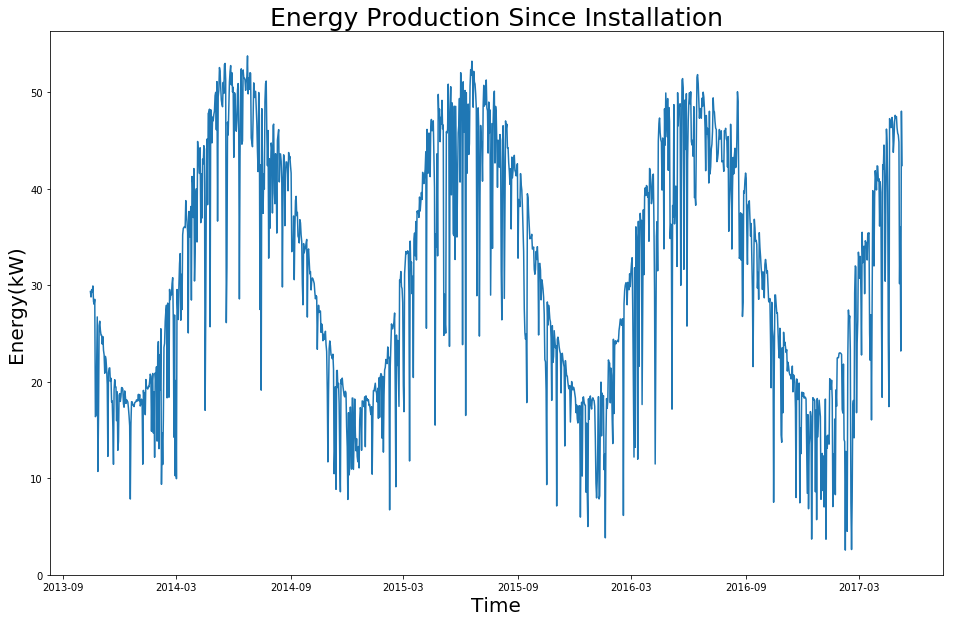

In [3]:
plt.plot(data["Dateobs"], data["Energy Produced (Wh)"]/1000, "-")
fig = plt.gcf()
fig.set_size_inches(16,10)
plt.title("Energy Production Since Installation", size=25)
ax = plt.gca()
ax.set_ylabel("Energy(kW)", size = 20)
ax.set_xlabel("Time", size = 20)

From this graph I conclude three things
- It seems that the time of year has a significant effect on the production.
- The production trends slightly downward at the years go by. This is possibly due to system age.
- There are many low spikes that seem to not be closly linked with the season.

It is my guess that these spikes are caused by the weather affecting the efficiency of the solar panels.

# Exploring the affect of weather

To explore the affect of weather, we have to control for the effects of non weather factors. One reasonable method might be to esimate the energy production based soley in the time of year and the aging of the panels.    

## _Controling for season_

To control for season could be realtively simple. If we assume the affects of season is caused by day lenth then we could use day length to help us predict energy production with weather heald constant.  

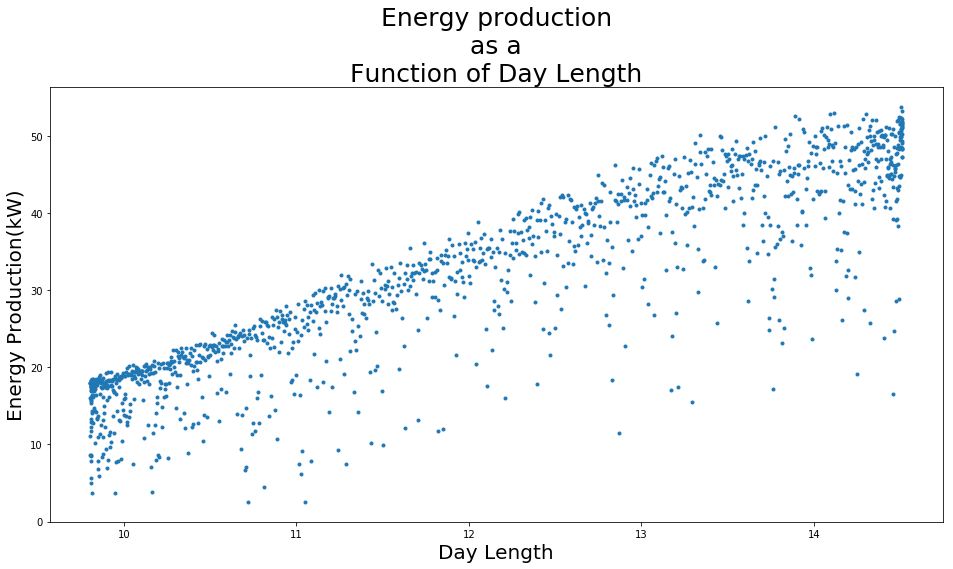

In [4]:
#fiiting a line to this and using that line to predict form does not tak into account the degredation of the pannels.
plt.plot(data.day_length/60/60, data["Energy Produced (Wh)"]/1000, ".")
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(16,8)
ax.set_ylabel("Energy Production(kW)", size = 20)
ax.set_xlabel("Day Length", size = 20)
plt.title("Energy production\nas a\nFunction of Day Length", size= 25)

Fiting a line to this data may give us an idea of what production would be if we accounted for day length but it would not control for panel ageing.

## Constructing a model that describes energy produciton due to season and age.

From the first graph it seems that the seasonal effect is sinusoidal while the aging affect is linear(According to the manufacturer of our panels, the panels lose 20% of there efficiency after 25 years). There for we can construct a linear equation for energy production as follows:

𝑃𝑜𝑤𝑒𝑟=𝐴𝑠𝑖𝑛(ω𝑡+ϕ)(1−D∗t)

Where:

A = summer winter fluctuation, 
ω = frequency of the season oscillation, 
ϕ = phase shift factor(aligns function along time axis to the data), and
D = Decay rate of efficiency due to aging  

Using this equation as a template we can fit this equation to our data using fmin search. 




In [5]:
#using numerical methods to fit a theroetical function to the data data which models the production if weather was held constant: 

#seed values fo fmin search
phase_offset = np.pi /0.88
Amplitude = 18000.00
DC_shift = 32747.88298
season = lambda x: sum(np.sqrt((data["Energy Produced (Wh)"] - ((x[0] *np.sin(((2*np.pi)/365)*data["index"] + x[1])) + x[2])* (1-(.2/9125)*data["index"]))**2))

seed = [Amplitude, phase_offset, DC_shift]
Xu = scipy.optimize.fmin(func=season, x0=seed, maxiter=100000)
#sum(data["data Produced (Wh)"] - data.model)
#Store the projected Constant weather production values.
data["model"] = ((Xu[0] *np.sin(((2*np.pi)/365)*data["index"] + Xu[1])) + Xu[2])* (1-(.2/9125)*data["index"])
Xu

Optimization terminated successfully.
         Current function value: 4891956.025264
         Iterations: 194
         Function evaluations: 362


array([  1.64893543e+04,   3.60263323e+00,   3.44070218e+04])

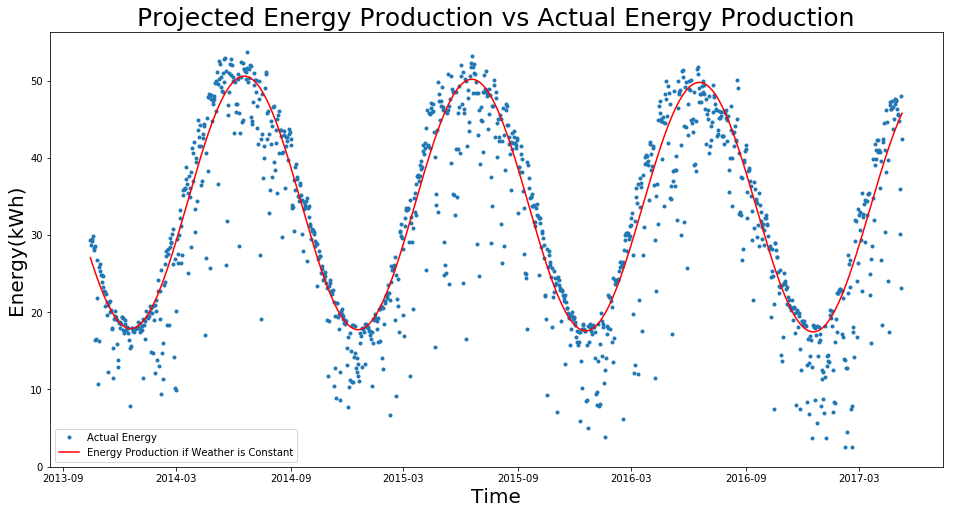

In [6]:
plt.plot(data["Dateobs"].dt.date, data["Energy Produced (Wh)"]/1000,".", label="Actual Energy")
plt.plot(data["Dateobs"], data["model"]/1000, "r-", label= "Energy Production if Weather is Constant")
fig = plt.gcf()
fig.set_size_inches(16,8)
ax = plt.gca()
ax.set_ylabel("Energy(kWh)",size = 20)
ax.set_xlabel("Time", size = 20)
plt.legend()
plt.title("Projected Energy Production vs Actual Energy Production", size= 25)

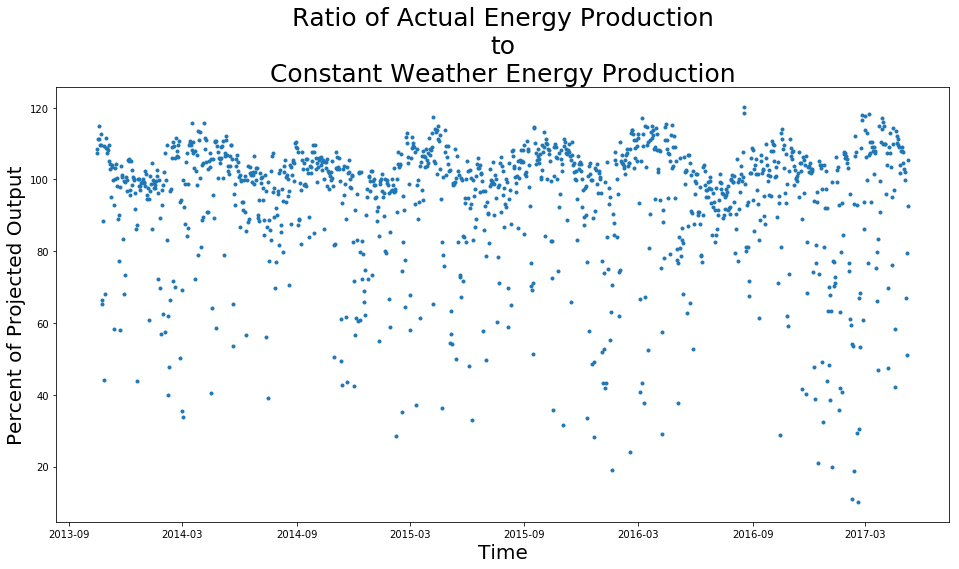

In [7]:
#get data as a percentage of theoretical model
data["percent_of_projected"] = (data["Energy Produced (Wh)"]/data["model"])*100
plt.plot(data["Dateobs"], data["percent_of_projected"], ".")
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(16,8)
ax.set_ylabel("Percent of Projected Output", size = 20)
ax.set_xlabel("Time", size = 20)
plt.title("Ratio of Actual Energy Production\nto\nConstant Weather Energy Production", size= 25)

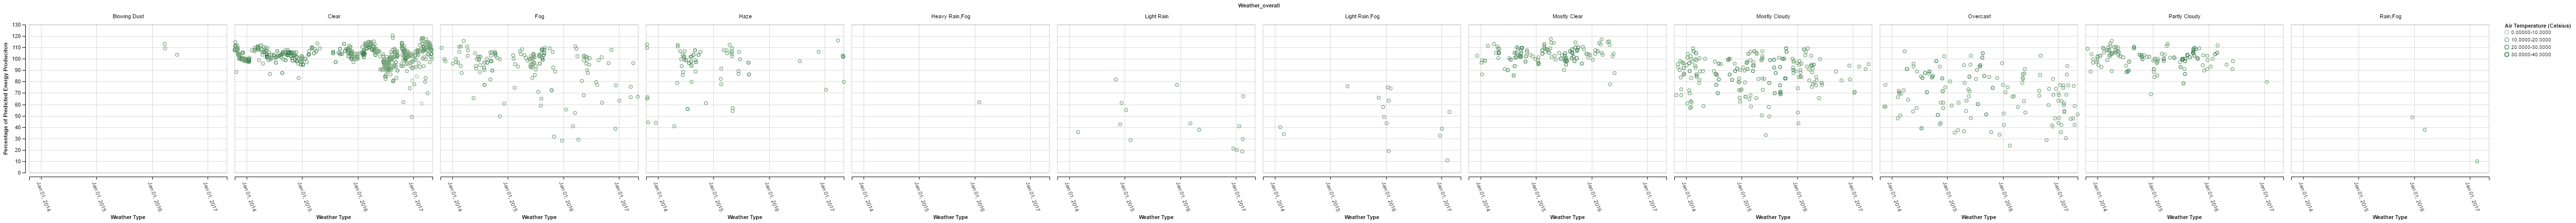

In [8]:
data2 = data.copy()
data2.Weather_overall = data.Weather_overall.fillna("null")
data2 = data2.loc[data2.Weather_overall != "null", :]
x = Chart(data2).mark_point().encode(
    x=X('Dateobs', axis=Axis(title='Weather Type', labelAngle=70, labelAlign="bottom")),
    y=Y('percent_of_projected', axis=Axis(title='Percentage of Predicted Energy Produciton')),
    color = Color("air_temp_set_1", title="Air Temperature (Celsius)", bin =Bin(maxbins=3)),
    column = 'Weather_overall'
    #shape = Shape("air_temp_set_1", title="Air Temperature (Celsius)", bin =Bin(maxbins=3))
    ).configure_cell(height=300, width=400)
x

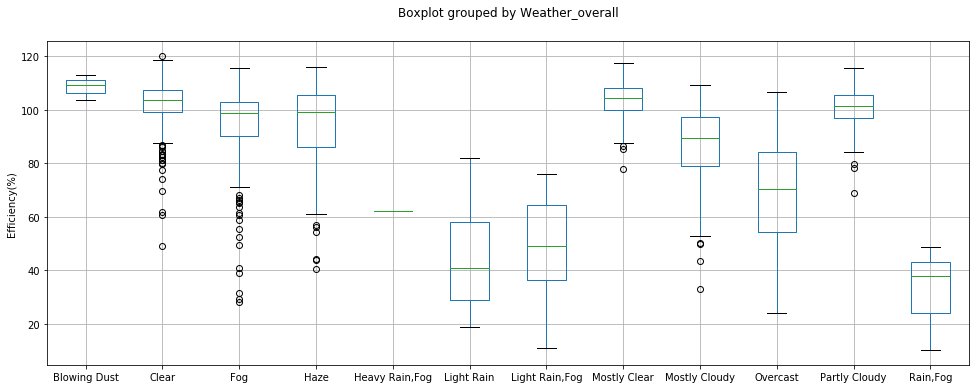

In [9]:
data.boxplot('percent_of_projected', by="Weather_overall")
fig = plt.gcf()
fig.set_size_inches(16,6)
plt.title("")
ax = plt.gca()
ax.set_ylabel("Efficiency(%)")
ax.set_xlabel("")


The charts above give us an idea of the effect that reported weather types have on efficiancy:
- Clear days generally have high efficianct 
- Fog and haze does not seem to lower the efficiency very much on average.
- Overcast conditions lower the efficiancy most with rainy conditions lowering the average efficiency to below 50%  


# Efficiency trends in Quantitative Weather Metrics

Now lets see if we can see any effect on efficancy looking at numrical weather readings of:
- Temperature
- Pressure
- Humidity
- Wind Speed

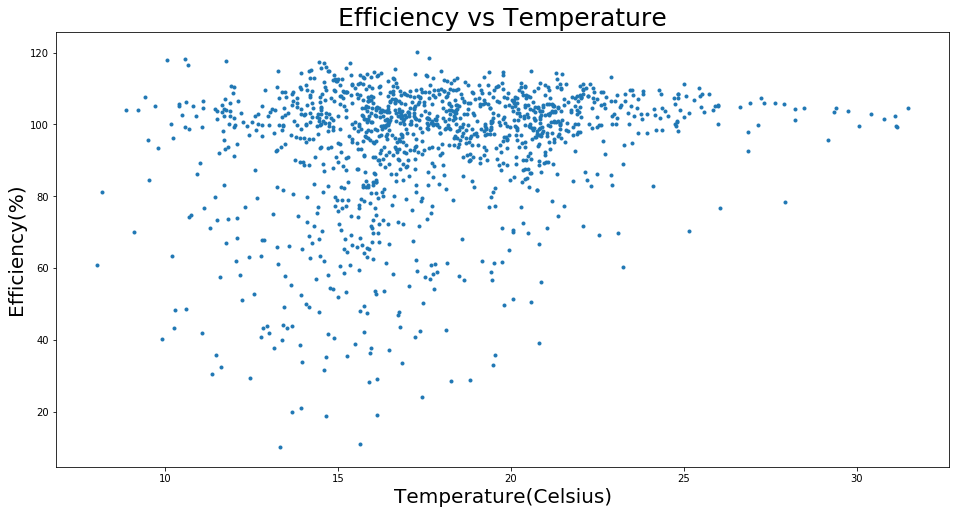

In [10]:
plt.plot(data.air_temp_set_1 , data["percent_of_projected"], ".")
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(16,8)
ax.set_ylabel("Efficiency(%)", size = 20)
ax.set_xlabel("Temperature(Celsius)", size = 20)
plt.title("Efficiency vs Temperature", size= 25)

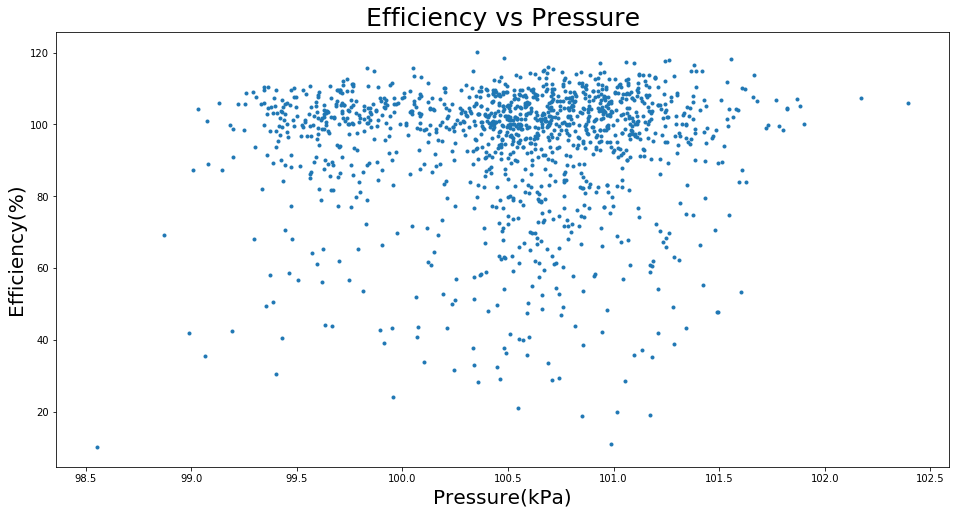

In [11]:
plt.plot(data.pressure_set_1d/1000, data["percent_of_projected"], ".")
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(16,8)
ax.set_ylabel("Efficiency(%)", size = 20)
ax.set_xlabel("Pressure(kPa)", size = 20)
plt.title("Efficiency vs Pressure", size= 25)

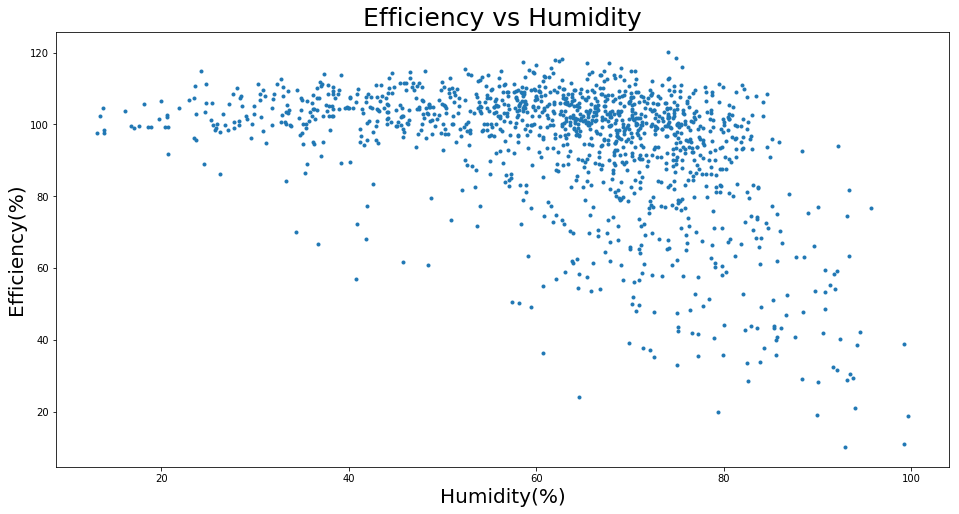

In [12]:
plt.plot(data.relative_humidity_set_1, data["percent_of_projected"], ".")
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(16,8)
ax.set_ylabel("Efficiency(%)", size = 20)
ax.set_xlabel("Humidity(%)", size = 20)
plt.title("Efficiency vs Humidity", size= 25)

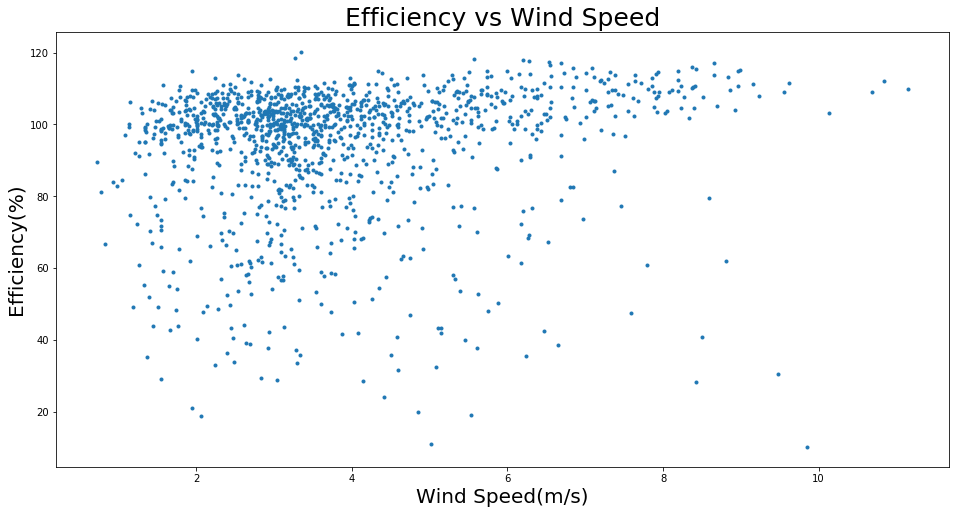

In [13]:
plt.plot(data.wind_speed_set_1, data["percent_of_projected"], ".")
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(16,8)
ax.set_ylabel("Efficiency(%)", size = 20)
ax.set_xlabel("Wind Speed(m/s)", size = 20)
plt.title("Efficiency vs Wind Speed", size= 25)

In [14]:
data.to_csv("/home/tmgerrit/Data301/Final Project/MLdata.csv", index = False)